# Enhanced protein isoform characterization through long-read proteogenomics 
## Figure 6
#### Ben Jordan

In [1]:
import pandas as pd 
import numpy as np
import os
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
import os, sys
import matplotlib
from matplotlib import colors


import config, data_loader

matplotlib.rc('font', **config.font)

# all plots go into a directory
if not os.path.exists('plot'):
    os.makedirs('plot')

# all statistics go into a directory
if not os.path.exists('stats'):
    os.makedirs('stats')

### Fig 6b, The number of protein groups identified in a traditional (normal) search versus one that incorporates long-read RNA-seq data to rescue isoforms (Rescue & Resolve algorithm). 

In [2]:
sample_name='jurkat'
hybrid_protein_groups_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/metamorpheus/pacbio/hybrid/search_results/Task1SearchTask/AllQuantifiedProteinGroups.{sample_name}.hybrid.tsv'
rescue_resolve_protein_groups_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/metamorpheus/pacbio/rescue_resolve/search_results/Task1SearchTask/AllQuantifiedProteinGroups.{sample_name}.rescue_resolve.tsv'
high_confidence_genes_file =  f'{config.PIPELINE_RESULTS_DIRECTORY}/hybrid_protein_database/jurkat_high_confidence_genes.tsv'
pacbio_genes_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_classification/jurkat_genes.tsv'
gene_isoname_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/reference_tables/gene_isoname.tsv'
refined_file = f'{config.PIPELINE_RESULTS_DIRECTORY}/protein_gene_rename/jurkat_orf_refined_gene_update.tsv'
#********************************************
# Load data
#********************************************
isoname_gene = pd.read_table(gene_isoname_file, header=None)
pb_genes = pd.read_table(pacbio_genes_file)
gencode_gene_map = pd.Series(isoname_gene[0].values, index=isoname_gene[1]).to_dict()
pacbio_gene_map = pd.Series(pb_genes.pr_gene.values,index=pb_genes.pb).to_dict()
hybrid_gene_map = {**gencode_gene_map, **pacbio_gene_map}
high_confidence_genes = list(pd.read_table(high_confidence_genes_file, header=None, names=['gene'])['gene'])
cpm_data = pd.read_table(refined_file, usecols=['base_acc', 'pr_gene','CPM'])
acc_cpm = pd.Series(cpm_data.CPM.values,index=cpm_data.base_acc).to_dict()
gene_cpm = cpm_data.groupby('pr_gene')['CPM'].sum().reset_index()
gene_cpm = pd.Series(gene_cpm.CPM.values,index=gene_cpm.pr_gene).to_dict()

def expand_peptides(peptide):
    if pd.isna(peptide):
        return []
    return peptide.split('|')

def is_high_confidence_gene_in_protein_group(protein_group, gene_map, high_confidence_genes):
    for isoform in protein_group.split('|'):
        if isoform in gene_map.keys():
            gene = gene_map[isoform]
            if gene in high_confidence_genes:
                return True
    return False

hybrid_protein_groups = (
    pd.read_table(
        hybrid_protein_groups_file, 
        index_col=False,
        usecols=[0,6,7,16,19], 
        names=['protein_group','unique_peptides','shared_peptides','dct','qval'], 
        skiprows=1)
    .query('dct == "T"') 
    .set_index('protein_group')
)
hybrid_protein_groups['unique_peptides'] = hybrid_protein_groups['unique_peptides'].apply(expand_peptides)
hybrid_protein_groups['num_unique_peptides'] = hybrid_protein_groups['unique_peptides'].apply(lambda x: len(x))

hybrid_protein_groups['shared_peptides'] = hybrid_protein_groups['shared_peptides'].apply(expand_peptides)
hybrid_protein_groups['all_peptides'] = hybrid_protein_groups['unique_peptides'] + hybrid_protein_groups['shared_peptides']

rescue_resolve_protein_groups = (
    pd.read_table(rescue_resolve_protein_groups_file,
    index_col=False,
    usecols=[0,1,6,7,16,19], 
    names=['protein_group','gene','unique_peptides','shared_peptides','dct','qval'], 
    skiprows=1)
    .query('qval <= 0.01 and dct == "T"')
    .set_index('protein_group')
    
)



rescue_resolve_protein_groups['unique_peptides'] = rescue_resolve_protein_groups['unique_peptides'].apply(expand_peptides)
rescue_resolve_protein_groups['shared_peptides'] = rescue_resolve_protein_groups['shared_peptides'].apply(expand_peptides)
rescue_resolve_protein_groups['all_peptides'] = rescue_resolve_protein_groups['unique_peptides'] + rescue_resolve_protein_groups['shared_peptides']
rescue_resolve_protein_groups = rescue_resolve_protein_groups[rescue_resolve_protein_groups.apply(lambda row: is_high_confidence_gene_in_protein_group(row.name, hybrid_gene_map, high_confidence_genes), axis=1)]

#********************************************
# Assign rescue cases
#********************************************
def is_candidate_group(candidate_group_peptides,rescued_group_peptides):
    for pep in rescued_group_peptides:
        if pep in candidate_group_peptides:
            return True
    return False

def is_rescued_subset(candidate_group_peptides, rescued_group_peptides):
    for pep in rescued_group_peptides:
        if pep not in candidate_group_peptides:
            return False
    return True

# def table_rescued_groups(rescue_resolve_protein_groups, hybrid_protein_groups,acc_cpm, gene_cpm ):
#     hybrid_group_accs = set(hybrid_protein_groups.index)
#     rr_group_accs = set(rescue_resolve_protein_groups.index)
#     rescued_group_accs = rr_group_accs - hybrid_group_accs
#     rescued_groups = rescue_resolve_protein_groups.loc[rescued_group_accs]
#     rescued_groups['accessions'] = rescued_groups.apply(lambda row: row.name.split('|'), axis=1 )
#     rescued_groups['absolute_CPM']= rescued_groups['accessions'].apply(lambda accs: [round(acc_cpm[x],2) for x in accs])
#     rescued_groups['total_CPM'] = rescued_groups['absolute_CPM'].apply(lambda cpm: round(sum(cpm),2))
#     rescued_groups['relative_CPM'] = rescued_groups.apply(lambda row: [round(abs_cpm/row['total_CPM'],2) for abs_cpm in row['absolute_CPM']],axis=1)
#     rescued_groups['absolute_CPM'] = rescued_groups['absolute_CPM'].apply(lambda cpm: '|'.join([str(x) for x in cpm]))
#     rescued_groups['relative_CPM'] = rescued_groups['relative_CPM'].apply(lambda cpm: '|'.join([str(x) for x in cpm]))

#     rescued_groups['gene_CPM'] = rescued_groups['gene'].apply(lambda genes: '|'.join([str(round(gene_cpm[gene],2)) for gene in genes.split('|')]))
#     rescued_groups = rescued_groups.reset_index()
#     rescued_groups[['gene','protein_group','absolute_CPM', 'relative_CPM','total_CPM', 'gene_CPM']].to_csv('stats/SuppTableX_rescued_CPMs.tsv', sep='\t')

#     rescued_groups = rescued_groups[['protein_group','gene', 'absolute_CPM', 'relative_CPM','total_CPM','gene_CPM']]
#     rescued_groups['accession'] = rescued_groups['protein_group'].str.split('|')
#     rescued_groups['gene'] = rescued_groups['gene'].str.split('|')
#     rescued_groups['absolute_CPM'] = rescued_groups['absolute_CPM'].str.split('|')
#     rescued_groups['relative_CPM'] = rescued_groups['relative_CPM'].str.split('|')
#     rescued_groups['total_CPM'] = rescued_groups.apply(lambda row: [row['total_CPM'] for a in row['accession']],axis=1)
#     # rescued_groups['total_CPM'] = rescued_groups['total_CPM'].str.split('|')
#     rescued_groups['gene_CPM'] = rescued_groups['gene_CPM'].str.split('|')
#     rescued_groups_explode = rescued_groups.set_index('protein_group').apply(pd.Series.explode).reset_index()
#     rescued_groups_explode = rescued_groups_explode[['protein_group','accession','gene', 'absolute_CPM', 'relative_CPM','total_CPM','gene_CPM']]

#     rescued_groups_explode.to_csv('stats/SuppTableX_exploded_rescued_CPM.tsv', sep='\t', index=False)
    

# table_rescued_groups(rescue_resolve_protein_groups, hybrid_protein_groups, acc_cpm, gene_cpm)

def assign_resuce_cases(rescue_resolve_protein_groups, hybrid_protein_groups):
    hybrid_group_accs = set(hybrid_protein_groups.index)
    rr_group_accs = set(rescue_resolve_protein_groups.index)
    rescued_group_accs = rr_group_accs - hybrid_group_accs
    print(len(rescued_group_accs))
    case1a=[]
    case1b=[]
    case2=[]
    for group in rescued_group_accs:
        rescued_group_peptides = rescue_resolve_protein_groups.at[group,'all_peptides']
        candidate_origin_groups = hybrid_protein_groups[hybrid_protein_groups.apply(lambda x: is_candidate_group(x['all_peptides'], rescued_group_peptides), axis=1)]
        candidate_origin_groups['is_subset'] = candidate_origin_groups.apply(lambda x: is_rescued_subset(x['all_peptides'], rescued_group_peptides), axis=1)
        candidate_subset = candidate_origin_groups[candidate_origin_groups['is_subset']]
        candidate_subsumable = candidate_origin_groups[~candidate_origin_groups['is_subset']]
        subsumable_peptides = set()
        
        for peptides in candidate_subsumable['all_peptides']:
            subsumable_peptides.update(peptides)
        # Case 1a having unique peptides and being a subset gets top priority
        if len(candidate_subset)>0 and candidate_subset['num_unique_peptides'].sum() > 0:
            case1a.append(group)
        else:
            
            # case 2 gets next priority but only for cases where at least one of the parent groups 
            # has a unique peptide and all the peptides for the
            # rescued group can be accounted for by the parent "subsumable" groups
            if candidate_subsumable['num_unique_peptides'].sum() > 0:
                
                if is_rescued_subset(subsumable_peptides, rescued_group_peptides):
                    case2.append(group)
                # if the "subsumable" parents cannot cover all of the peptides, 
                # and there is a subset group with only shared peptides 
                # - this is the categorization
                elif len(candidate_subset)>0:
                    case1b.append(group)
                else:
                    raise Exception("Invalid case: subsumable does not cover all peptides and no subset found")
            else:
                # if there is a subset and all peptides are shared then case1b
                if len(candidate_subset)>0:
                    case1b.append(group)
                # no subset, if subsumable peptides can explain rescued peptides then case2
                elif is_rescued_subset(subsumable_peptides, rescued_group_peptides):
                    case2.append(group)
                else:
                    raise Exception("Invalid case: all shared peptides.\nNo subset\nSubsumable does not cover peptides")
    return case1a, case1b, case2
case1a, case1b, case2 = assign_resuce_cases(rescue_resolve_protein_groups, hybrid_protein_groups)
#********************************************
# Save Stats
#********************************************
hybrid_group_accs = set(hybrid_protein_groups.index)
rr_group_accs = set(rescue_resolve_protein_groups.index)
rescued_group_accs = rr_group_accs - hybrid_group_accs
with open(f'stats/Fig6d_rescued_protein_group_classification_summary_stats.tsv','w') as ofile:
    ofile.write('Case\tNumber of Protein Groups\tPercent\n')
    ofile.write(f'case1a\t{len(case1a)}\t{len(case1a)/len(rescued_group_accs)*100:.2f}\n')
    ofile.write(f'case1b\t{len(case1b)}\t{len(case1b)/len(rescued_group_accs)*100:.2f}\n')
    ofile.write(f'case2\t{len(case2)}\t{len(case2)/len(rescued_group_accs)*100:.2f}\n')
    
with open('stats/Fig6b_rescued_protein_groups_classification.tsv','w') as ofile:
    # ofile.write('protein_group\tclassification\n')
    for caselist, rrclass in zip([case1a,case1b,case2],['case1a','case1b','case2']):
        for acc in caselist:
            ofile.write(f'{acc}\t{rrclass}\n')


pb_col = config.database_colors['PacBio']
pb_rr_col = config.database_colors['PacBio Rescue Resolve']




355
<ipython-input-2-59218505fc5a>:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_origin_groups['is_subset'] = candidate_origin_groups.apply(lambda x: is_rescued_subset(x['all_peptides'], rescued_group_peptides), axis=1)


In [3]:
len(hybrid_group_accs)

8454

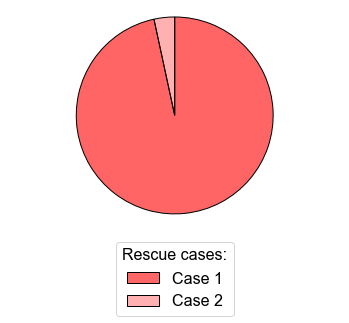

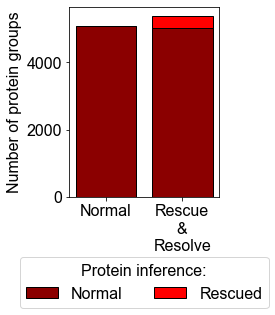

In [4]:
pb_col = config.database_colors['PacBio']
pb_rr_col = config.database_colors['PacBio Rescue Resolve']

#********************************************
# Pie Plot
#********************************************
labels = ['Case 1',  'Case 2']

case1_size = len(case1a)+len(case1b)
case2_size = len(case2)
total = (len(case1a)+len(case1b)+len(case2))
case_1_color = [c for c in colors.to_rgb(config.database_colors['PacBio Rescue Resolve'])] + [0.6]
case_2_color = [c for c in colors.to_rgb(config.database_colors['PacBio Rescue Resolve'])] + [0.3]


sizes = [case1_size, case2_size]
fig1, ax = plt.subplots()
pie_object = ax.pie(
    sizes,  
    colors=[case_1_color, case_2_color],
    wedgeprops={'edgecolor':'black'},
    startangle=90,
    counterclock=False,)
wedges,_ = pie_object
# set wedges to be different extent of alphas
# pie_object[0][0].set_alpha(0.5)
# pie_object[0][1].set_alpha(0.5)
# pie_object[0][1].set_alpha(0.8)
ax.legend(wedges, labels,title='Rescue cases:', loc='center', bbox_to_anchor=(0.5, -0.25), ncol=1)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("plot/Fig6b_rescued_protein_group_classification_pie.pdf", bbox_inches='tight')

#********************************************
# Bar plot
#********************************************
hybrid_protein_groups = hybrid_protein_groups[hybrid_protein_groups.apply(lambda row: is_high_confidence_gene_in_protein_group(row.name, hybrid_gene_map, high_confidence_genes), axis=1)]
hybrid_size = len(hybrid_protein_groups.query('qval <= 0.01'))
rescue_resolve_size = len(rescue_resolve_protein_groups)
rescued_size = len(rr_group_accs - hybrid_group_accs)
fig, ax = plt.subplots(figsize=(2.7,3.5))
labels = ['Normal','Rescue\n&\nResolve']
non_rescued_sizes = [hybrid_size,rescue_resolve_size - rescued_size ]
rescued_sizes = [0, rescued_size]
ax.bar(labels, non_rescued_sizes, label='Normal', color=pb_col, edgecolor='black')
ax.bar(labels, rescued_sizes, bottom=non_rescued_sizes, label='Rescued', color=pb_rr_col, edgecolor='black')
ax.set_ylabel('Number of protein groups')
ax.legend(title='Protein inference:', loc='center', bbox_to_anchor=(0.5, -0.45), ncol=3)
plt.savefig("plot/Fig6b_rescued_protein_group_barplot_comparison.pdf", bbox_inches='tight')
with open(f'stats/Fig6b_rescued_protein_group_barplot_comparison.tsv', 'w') as ofile:
    ofile.write(f'Normal\t{hybrid_size}\n')
    ofile.write(f'Rescued size\t{rescued_size}\n')

### Fig6e, The percent of rescued protein isoforms validated compared to the derived distribution from randomly rescued isoforms.

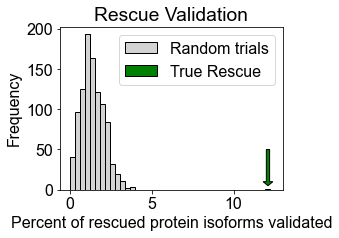

<Figure size 432x288 with 0 Axes>

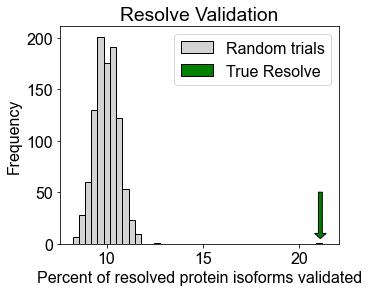

<Figure size 432x288 with 0 Axes>

In [5]:
import pandas as pd

import os, sys
import matplotlib
import config
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

matplotlib.rc('font', **config.font)

bins = 40
random_color = 'lightgrey'
true_color = 'green'

#--------------------------------------------
# Rescue Validation
#--------------------------------------------
filename = 'RescueValidationHistogramData.xlsx'
validation_data = pd.read_excel(filename)
validation_data['Percent Validated'] = validation_data['Percent Validated']*100
exp_valid = validation_data.loc[0]['Percent Validated']

fig, ax = plt.subplots(figsize=(4,3))
N, bins, patches = ax.hist(validation_data['Percent Validated'], color=random_color, edgecolor='black', bins = bins)
patches[-1].set_facecolor(true_color)
ax.set_xlabel('Percent of rescued protein isoforms validated')
ax.set_ylabel('Frequency')
ax.set_title('Rescue Validation')

legend_elements = [
                   Patch(facecolor=random_color, edgecolor='black',
                         label='Random trials'),
                         Patch(facecolor=true_color, edgecolor='black',
                         label='True Rescue')]
ax.legend(handles=legend_elements)
plt.arrow(exp_valid-0.1, 50, 0,-40,head_length=5, width=0.2,facecolor=true_color, edgecolor='black')
plt.savefig('plot/Fig6d_rescue_emperical_p_histplot.pdf', bbox_inches='tight' )
plt.show()
plt.clf()



#--------------------------------------------
# Resolve Validation
#--------------------------------------------
filename = 'ResolveValidationHistogramData_update.xlsx'
bins = 40
validation_data = pd.read_excel(filename)
validation_data['Percent Validated'] = validation_data['Percent Validated']*100
exp_valid = validation_data.loc[0]['Percent Validated']

fig, ax = plt.subplots(figsize=(5,4))
N, bins, patches = ax.hist(validation_data['Percent Validated'], color=random_color, edgecolor='black', bins = bins)
patches[-1].set_facecolor(true_color)
ax.set_xlabel('Percent of resolved protein isoforms validated')
ax.set_ylabel('Frequency')
ax.set_title('Resolve Validation')

legend_elements = [
                   Patch(facecolor=random_color, edgecolor='black',
                         label='Random trials'),
                         Patch(facecolor=true_color, edgecolor='black',
                         label='True Resolve')]
ax.legend(handles=legend_elements)
plt.arrow(exp_valid-0.1, 50, 0,-40,head_length=5, width=0.2,facecolor=true_color, edgecolor='black')
plt.savefig('plot/Fig6e_resolve_emperical_p_histplot.pdf', bbox_inches='tight' )
plt.show()
plt.clf()

